In [21]:
# Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.graph_objects as go
from scenario import*
from scipy.optimize import curve_fit
from scipy.stats import t

import numpy as np

In [22]:
# Extracting of scenarios from indoor logs
coaxial_directory = r'data\coaxial\logs'
indoor_directory = r'data\indoor\logs'
outdoor_directory = r'data\outdoor\logs'

scenarios_indoor = extract_scenarios_from_text_files(indoor_directory)
scenarios_coaxial = extract_scenarios_from_text_files(coaxial_directory)
scenarios_outdoor = extract_scenarios_from_text_files(outdoor_directory)

scenarios_indoor_1M = []
scenarios_indoor_2M = []
for scenario in scenarios_indoor:
    if scenario.test_type == 'indoor':
        if scenario.bandwidth == '1M':
            scenarios_indoor_1M.append(scenario)
        elif scenario.bandwidth == '2M':
            scenarios_indoor_2M.append(scenario)

scenarios_coaxial_1M = []
scenarios_coaxial_2M = []
for scenario in scenarios_coaxial:
    if scenario.test_type == 'coaxial':
        if scenario.bandwidth == '1M' :
            scenarios_coaxial_1M.append(scenario)
        elif scenario.bandwidth == '2M':
            scenarios_coaxial_2M.append(scenario)

scenarios_outdoor_1M = []
scenarios_outdoor_2M = []
for scenario in scenarios_outdoor:
    if scenario.test_type == 'outdoor':
        if scenario.bandwidth == '1M' :
            scenarios_outdoor_1M.append(scenario)
        elif scenario.bandwidth == '2M':
            scenarios_outdoor_2M.append(scenario)
            

# To dataframe
df_all = scenarios_to_dataframe(scenarios_indoor + scenarios_coaxial)
df_1M = scenarios_to_dataframe(scenarios_coaxial_1M +scenarios_indoor_1M)
df_2M = scenarios_to_dataframe(scenarios_coaxial_2M +scenarios_indoor_2M)
df_indoor_1M = scenarios_to_dataframe(scenarios_indoor_1M)
df_indoor_2M = scenarios_to_dataframe(scenarios_indoor_2M)
df_coaxial_1M = scenarios_to_dataframe(scenarios_coaxial_1M)
df_coaxial_2M = scenarios_to_dataframe(scenarios_coaxial_2M)
df_outdoor_1M = scenarios_to_dataframe(scenarios_outdoor_1M)
df_outdoor_2M = scenarios_to_dataframe(scenarios_outdoor_2M)


atrium_tests
BC_tests
BM_tests
CO_tests
vortex_tests
atrium_tests
BC_tests
BM_tests
CO_tests
vortex_tests
results_indoor_STA_1MHz
results_indoor_STA_2MHz
floor_1_pos_1_1Mhz_indoor_1827.txt
floor_1_pos_2_1Mhz_indoor_1829.txt
floor_1_pos_3_1Mhz_indoor_1830.txt
floor_2_pos_1_1Mhz_indoor_1833.txt
floor_2_pos_2_1Mhz_indoor_1834.txt
floor_2_pos_2_1Mhz_indoor_1836.txt
floor_2_pos_3_1Mhz_indoor_1837.txt
floor_2_pos_3_1Mhz_indoor_1839.txt
point_floor_1_1Mhz_indoor_1621.txt
point_floor_2_1Mhz_indoor_1624.txt
point_floor_2_1Mhz_indoor_1637.txt
point_floor_2_1Mhz_indoor_1638.txt
point_floor_2_1Mhz_indoor_1640.txt
point_floor_3_1Mhz_indoor_1629.txt
point_floor_3_1Mhz_indoor_1631.txt
point_floor_4_1Mhz_indoor_1644.txt
point_floor_4_mv_1Mhz_indoor_1645.txt
floor_1_1Mhz_indoor_1706.txt
floor_1_pos_2_1Mhz_indoor_1707.txt
floor_1_pos_2_1Mhz_indoor_1711.txt
floor_1_pos_3_1Mhz_indoor_1710.txt
floor_2_pos_1_1Mhz_indoor_1715.txt
floor_2_pos_2_1Mhz_indoor_1716.txt
floor_2_pos_2_1Mhz_indoor_1717.txt
floor_2_p

In [23]:
# Setting Font size function
def set_global_fontsize_plt(title_size=16, label_size=14, tick_label_size=12, legend_size=12):
    """
    Set the font sizes for various elements in Matplotlib plots using the plt interface.

    Parameters:
    title_size (int): Font size for the title.
    label_size (int): Font size for the axis labels.
    tick_label_size (int): Font size for the tick labels.
    legend_size (int): Font size for the legend.
    """
    plt.rc('axes', titlesize=title_size)     # Set the title size globally
    plt.rc('axes', labelsize=label_size)     # Set the x and y label size globally
    plt.rc('xtick', labelsize=tick_label_size)  # Set the x tick label size globally
    plt.rc('ytick', labelsize=tick_label_size)  # Set the y tick label size globally
    plt.rc('legend', fontsize=legend_size)   # Set the legend font size globally

# Coaxial Setting

### Throughput vs RSSI: Sigmoid Function Model

The relationship between throughput (TP) and Received Signal Strength Indicator (RSSI) in wireless communication often exhibits an S-shaped or sigmoid curve. This behavior can be modeled using a logistic function.

#### Sigmoid Function Equation

The general form of the sigmoid function used to model the TP vs RSSI relationship is:

$ \text{TP}(rssi) = \frac{L}{1 + e^{-k (rssi - x_0)}} + b $

where:
- $\text{TP}(rssi)$ is the throughput at a given RSSI value.
- $L$ is the curve's maximum value (asymptote).
- $x_0$ is the RSSI value at the curve's midpoint.
- $k$ is the logistic growth rate or steepness of the curve.
- $b$ is the baseline throughput when RSSI is very low.

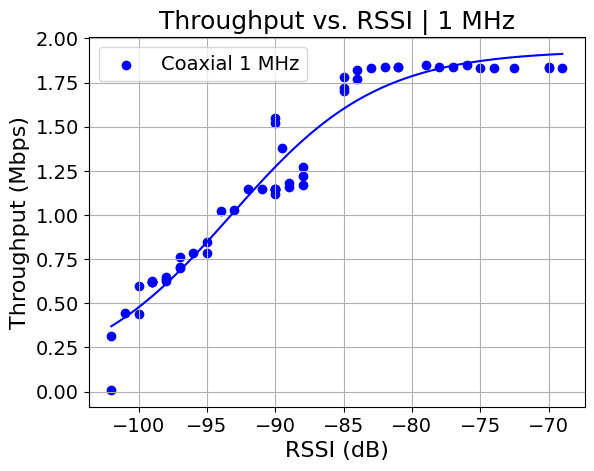

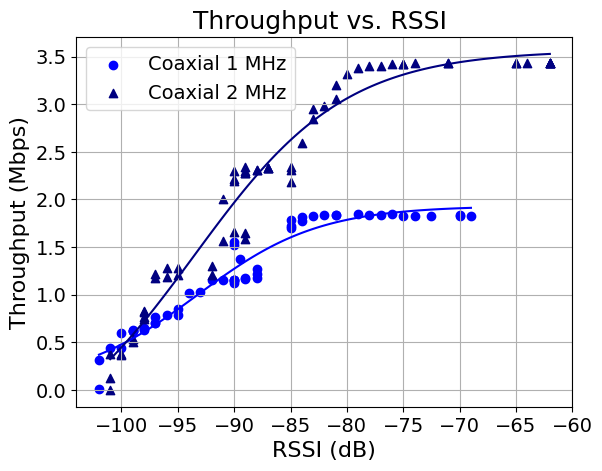

In [37]:
# Define the sigmoid model
def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

# Function to calculate confidence interval for the sigmoid model
def calculate_sigmoid_confidence_interval(x, popt, pcov, tval):
    J = np.array([sigmoid(x, *popt + np.eye(len(popt))[:,i]) - sigmoid(x, *popt) for i in range(len(popt))]).T
    var_y_fit = np.sum((J @ pcov) * J, axis=1)
    se_y_fit = np.sqrt(var_y_fit)
    ci = tval * se_y_fit
    return ci

# Function to fit the sigmoid model and plot the results
def fit_and_plot_throughput_vs_rssi(df, label, color, marker='o'):
    rssi_data = df['RSSI Median']
    throughput_data = df['RX iPerf Bitrate (Mbits/sec)']
    
    popt, pcov = curve_fit(sigmoid, rssi_data, throughput_data, p0=[max(throughput_data), np.median(rssi_data), 1, min(throughput_data)], maxfev=100000)
    perr = np.sqrt(np.diag(pcov))
    
    rssi_fit = np.linspace(min(rssi_data), max(rssi_data), 100)
    throughput_fit = sigmoid(rssi_fit, *popt)
    
    alpha = 0.95
    n = len(rssi_data)
    p = len(popt)
    dof = max(0, n - p)
    tval = t.ppf((1 + alpha) / 2., dof)
    
    confidence_interval = calculate_sigmoid_confidence_interval(rssi_fit, popt, pcov, tval)

    plt.scatter(rssi_data, throughput_data, label=label, color=color, marker=marker)
    plt.plot(rssi_fit, throughput_fit,  color=color) # label=f'Fit {label}: L={popt[0]:.2f}, x0={popt[1]:.2f}, k={popt[2]:.2f}, b={popt[3]:.2f}')
    # plt.fill_between(rssi_fit, throughput_fit - confidence_interval, throughput_fit + confidence_interval, color=color, alpha=0.2, label=f'Confidence interval {label}')

# df_theoretical = pd.DataFrame({'RSSI Median': RSSI, 'RX iPerf Bitrate (Mbits/sec)': TP})
# # Plotting the two curves
# plt.figure(figsize=(10, 6))
           
fit_and_plot_throughput_vs_rssi(df_coaxial_1M, 'Coaxial 1 MHz', 'blue', 'o')
# fit_and_plot_throughput_vs_rssi(df_coaxial_2M, 'Coaxial 2 MHz', 'navy', '^')
# fit_and_plot_throughput_vs_rssi(df_indoor_1M, 'Indoor 1 MHz', 'red', 'o')
# fit_and_plot_throughput_vs_rssi(df_indoor_2M, 'Indoor 2 MHz', 'darkorange', '^')

plt.xlabel('RSSI (dB)' , fontsize=16)
plt.ylabel('Throughput (Mbps)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.title('Throughput vs. RSSI | 1 MHz', fontsize=18)
plt.show()

fit_and_plot_throughput_vs_rssi(df_coaxial_1M, 'Coaxial 1 MHz', 'blue', 'o')
fit_and_plot_throughput_vs_rssi(df_coaxial_2M, 'Coaxial 2 MHz', 'navy', '^')
# fit_and_plot_throughput_vs_rssi(df_indoor_1M, 'Indoor 1 MHz', 'red', 'o')
# fit_and_plot_throughput_vs_rssi(df_indoor_2M, 'Indoor 2 MHz', 'darkorange', '^')

plt.xlabel('RSSI (dB)' , fontsize=16)
plt.ylabel('Throughput (Mbps)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.title('Throughput vs. RSSI ', fontsize=18)
plt.show()




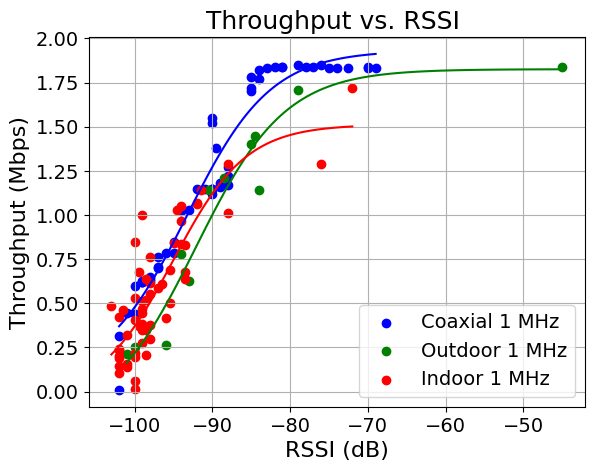

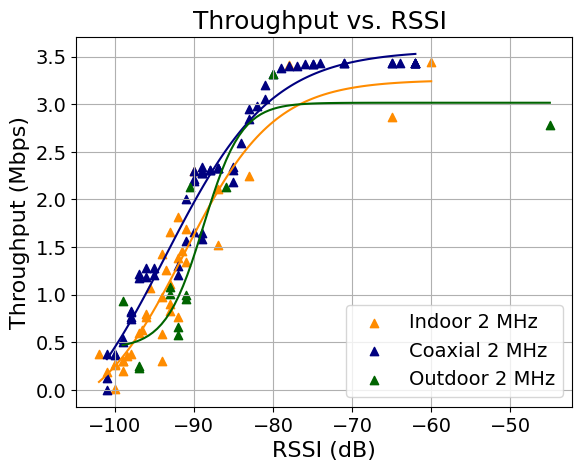

In [38]:
fit_and_plot_throughput_vs_rssi(df_coaxial_1M, 'Coaxial 1 MHz', 'blue', 'o')
fit_and_plot_throughput_vs_rssi(df_outdoor_1M, 'Outdoor 1 MHz', 'green', 'o')
fit_and_plot_throughput_vs_rssi(df_indoor_1M, 'Indoor 1 MHz', 'red', 'o')

# fit_and_plot_throughput_vs_rssi(df_indoor_1M, 'Indoor 1 MHz', 'red', 'o')
# fit_and_plot_throughput_vs_rssi(df_indoor_2M, 'Indoor 2 MHz', 'darkorange', '^')

plt.xlabel('RSSI (dB)' , fontsize=16)
plt.ylabel('Throughput (Mbps)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.title('Throughput vs. RSSI ', fontsize=18)
plt.show()

fit_and_plot_throughput_vs_rssi(df_indoor_2M, 'Indoor 2 MHz', 'darkorange', '^')
fit_and_plot_throughput_vs_rssi(df_coaxial_2M, 'Coaxial 2 MHz', 'navy', '^')
fit_and_plot_throughput_vs_rssi(df_outdoor_2M, 'Outdoor 2 MHz', 'darkgreen', '^')
plt.xlabel('RSSI (dB)' , fontsize=16)
plt.ylabel('Throughput (Mbps)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.title('Throughput vs. RSSI ', fontsize=18)
plt.show()

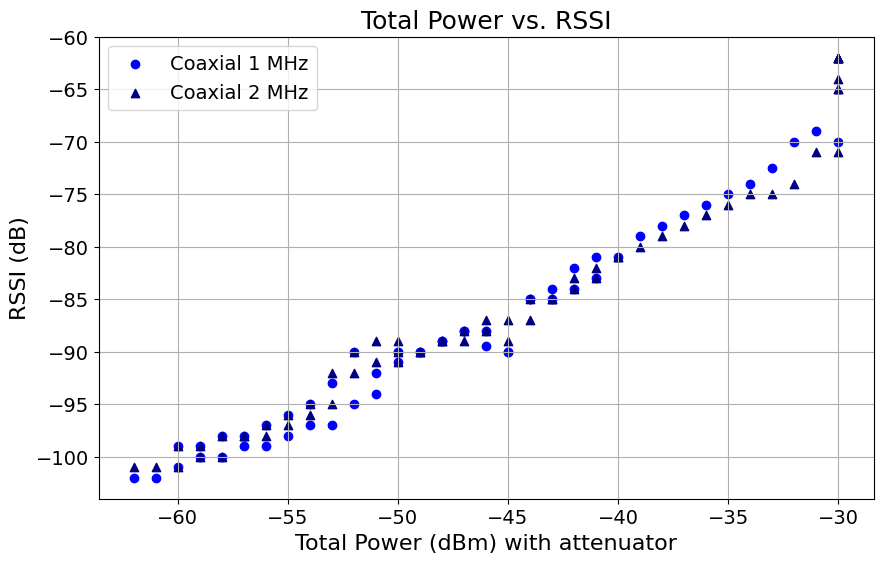

In [25]:
# Scatter plot Total Power vs RSSI

plt.figure(figsize=(10, 6))
plt.scatter(df_coaxial_1M['Total Gain'],df_coaxial_1M['RSSI Median'],  label='Coaxial 1 MHz', color='blue', marker='o')
plt.scatter(df_coaxial_2M['Total Gain'], df_coaxial_2M['RSSI Median'], label='Coaxial 2 MHz', color='navy', marker='^')

plt.ylabel('RSSI (dB)' , fontsize=16)
plt.xlabel('TX Gain + Attenuator value', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.title('Total Power vs. RSSI', fontsize=18)
plt.show()


# MCS vs RSSI Sensitivity Curve with Test Data Points

## Description

This graph represents the relationship between Modulation and Coding Scheme (MCS) and Received Signal Strength Indicator (RSSI). The step function demonstrates the sensitivity curve where MCS values stay constant until a specific RSSI threshold is reached, after which the MCS value steps up. The plot also includes test data points with different markers to distinguish between various data sets.

## Key Points

1. **Sensitivity Curve**:
   - The sensitivity curve is plotted as a step function, indicating the RSSI thresholds for each MCS value.
   - MCS values range from 10 to 7.
   - RSSI values are shown in dBm, increasing from left to right.

2. **Data Points**:
   - Test data points are plotted using circles and triangles to represent different types of data.
   - Red circles and blue triangles indicate the MCS values at specific RSSI measurements from the test data.

## Interpretation

- **MCS Levels**:
  - MCS levels remain constant until the RSSI value reaches the next threshold, indicating the minimum RSSI required for each MCS level.
  - For example, MCS -1 (representing 10) is valid until the RSSI reaches -98 dBm, after which MCS 0 becomes valid up to -95 dBm.

- **Test Data Points**:
  - The test data points help validate the sensitivity curve by showing actual measurements of MCS at various RSSI levels.
  - Differences in markers help distinguish between different sets of test data, providing a visual comparison.

## Technical Details

- **MCS vs RSSI Sensitivity Curve**:
  - MCS values: [-1, 0, 1, 2, 3, 4, 5, 6, 7]
  - RSSI thresholds: [-98, -95, -92, -90, -87, -83, -79, -78, -77]

- **Plotting Markers**:
  - Circles (`o`) represent 1Mhz measurments, Triangles (`^`) represent 2 MHz.
  - Red is used for coaxial setting and Blue for indoor.

The graph provides a comprehensive view of how MCS values change with varying RSSI, along with actual test measurements to validate the sensitivity curve.


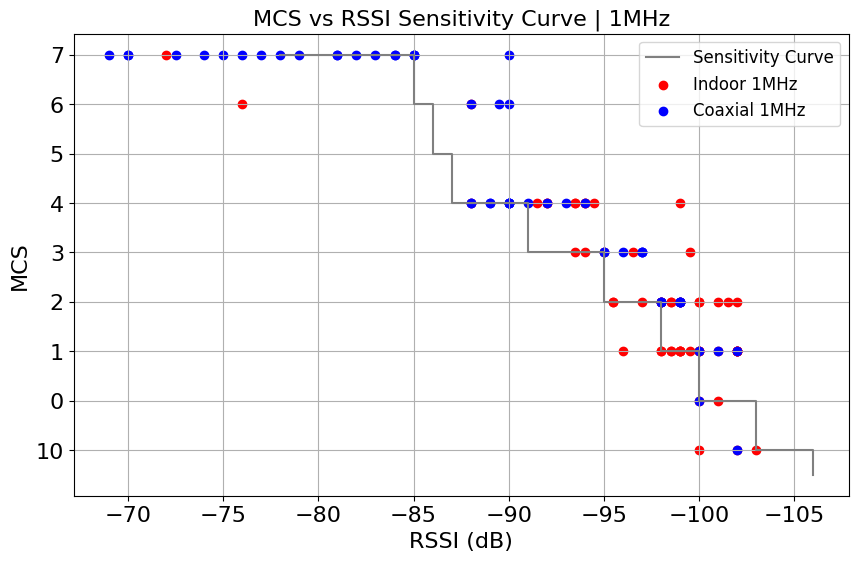

In [26]:
# Adjust the MCS and sensitivity values to reflect MCS 10 below 0
mcs_values = [-1, 0, 1, 2, 3, 4, 5, 6, 7]
sensitivity_values = [-98, -95, -92, -90, -87, -83, -79, -78, -77]

# Adjust for step plot with MCS 10 below 0


rssi_data = df_all['RSSI Median']
mcs_data = df_all['MCS']

offset = -8         # add 5 curves seems to fit

sensitivity_steps = [-98+offset]  # Start with a value below the first sensitivity
mcs_steps = [-1.5]  # Start with MCS 10

for i in range(len(mcs_values)):
    sensitivity_steps.append(sensitivity_values[i]+offset)
    mcs_steps.append(mcs_values[i])
    if i != len(mcs_values) - 1:
        sensitivity_steps.append(sensitivity_values[i+1]+offset)
        mcs_steps.append(mcs_values[i])
sensitivity_steps.append(-70+offset)
mcs_steps.append(7)

# Create the step plot
set_global_fontsize_plt(16, 14, 8, 8)

plt.figure(figsize=(10, 6))
plt.step(sensitivity_steps, mcs_steps, where='post', label='Sensitivity Curve', color='grey')

# Plot the test data points
mcs_indoor_1M = df_indoor_1M['MCS']

plt.scatter(df_indoor_1M['RSSI Median'], [-1 if x == 10 else x for x in df_indoor_1M['MCS']], color='red', marker='o', label='Indoor 1MHz')
# plt.scatter(df_indoor_2M['RSSI Median'], [-1 if x == 10 else x for x in df_indoor_2M['MCS']], color='darkorange', marker='^', label='Indoor 2MHz')
plt.scatter(df_coaxial_1M['RSSI Median'], [-1 if x == 10 else x for x in df_coaxial_1M['MCS']], color='blue', marker='o', label='Coaxial 1MHz')
# plt.scatter(df_coaxial_2M['RSSI Median'], [-1 if x == 10 else x for x in df_coaxial_2M['MCS']], color='navy', marker='^', label='Coaxial 2MHz')


plt.xlabel('RSSI (dB)', fontsize=16)
plt.ylabel('MCS', fontsize=16)
plt.title('MCS vs RSSI Sensitivity Curve | 1MHz', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks([-1, 0, 1, 2, 3, 4, 5, 6, 7], ['10', '0', '1', '2', '3', '4', '5', '6', '7'], fontsize=16)

plt.gca().invert_xaxis()  # Invert y-axis to have MCS in descending order
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

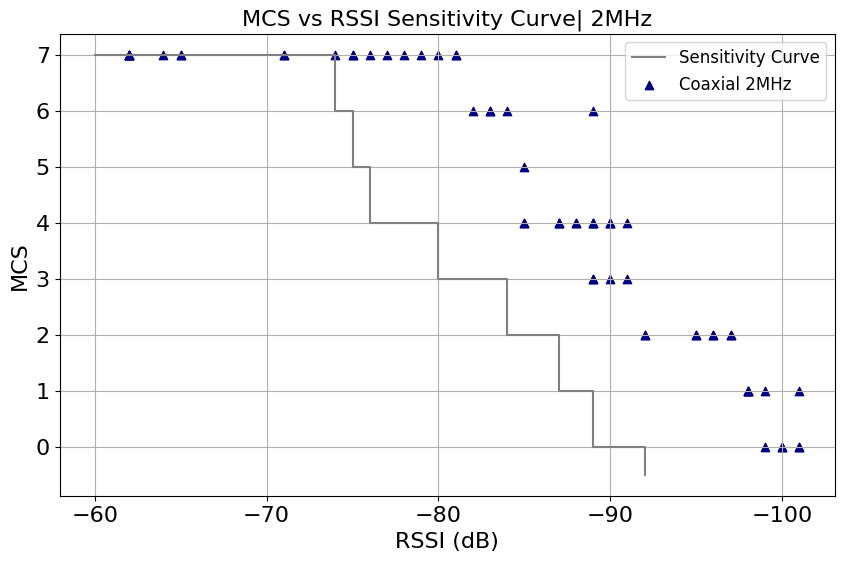

In [27]:
# Adjust the MCS and sensitivity values to reflect MCS 10 below 0
mcs_values = [0, 1, 2, 3, 4, 5, 6, 7]
sensitivity_values = [-92, -89, -87, -84, -80, -76, -75, -74]

# Adjust for step plot with MCS 10 below 0


rssi_data = df_all['RSSI Median']
mcs_data = df_all['MCS']

offset = 0 # add 5 curves seems to fit

sensitivity_steps = [-92+offset]  # Start with a value below the first sensitivity
mcs_steps = [-0.5]  # Start with MCS 10

for i in range(len(mcs_values)):
    sensitivity_steps.append(sensitivity_values[i]+offset)
    mcs_steps.append(mcs_values[i])
    if i != len(mcs_values) - 1:
        sensitivity_steps.append(sensitivity_values[i+1]+offset)
        mcs_steps.append(mcs_values[i])
sensitivity_steps.append(-60+offset)
mcs_steps.append(7)

# Create the step plot
set_global_fontsize_plt(16, 14, 8, 8)

plt.figure(figsize=(10, 6))
plt.step(sensitivity_steps, mcs_steps, where='post', label='Sensitivity Curve', color='grey')

# Plot the test data points
mcs_indoor_1M = df_indoor_1M['MCS']

# plt.scatter(df_indoor_1M['RSSI Median'], [-1 if x == 10 else x for x in df_indoor_1M['MCS']], color='red', marker='o', label='Indoor 1MHz')
# plt.scatter(df_indoor_2M['RSSI Median'], [-1 if x == 10 else x for x in df_indoor_2M['MCS']], color='darkorange', marker='^', label='Indoor 2MHz')
# plt.scatter(df_coaxial_1M['RSSI Median'], [-1 if x == 10 else x for x in df_coaxial_1M['MCS']], color='blue', marker='o', label='Coaxial 1MHz')
plt.scatter(df_coaxial_2M['RSSI Median'], [-1 if x == 10 else x for x in df_coaxial_2M['MCS']], color='navy', marker='^', label='Coaxial 2MHz')


plt.xlabel('RSSI (dB)', fontsize=16)
plt.ylabel('MCS', fontsize=16)
plt.title('MCS vs RSSI Sensitivity Curve| 2MHz', fontsize=16)
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7], ['0', '1', '2', '3', '4', '5', '6', '7'], fontsize=16)
plt.xticks(fontsize=16)

plt.gca().invert_xaxis()  # Invert y-axis to have MCS in descending order
plt.grid(True)
plt.legend(fontsize=12)

# Throughput vs MCS


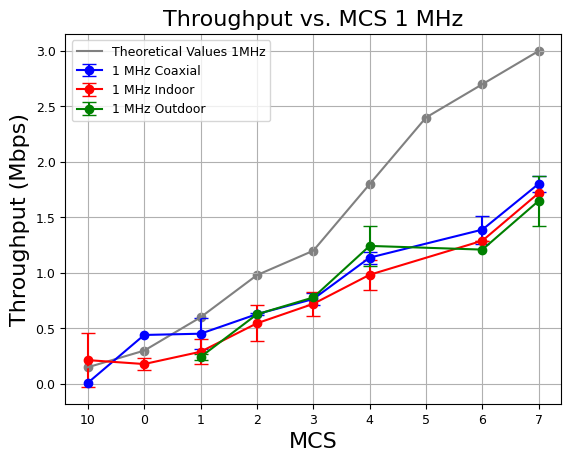

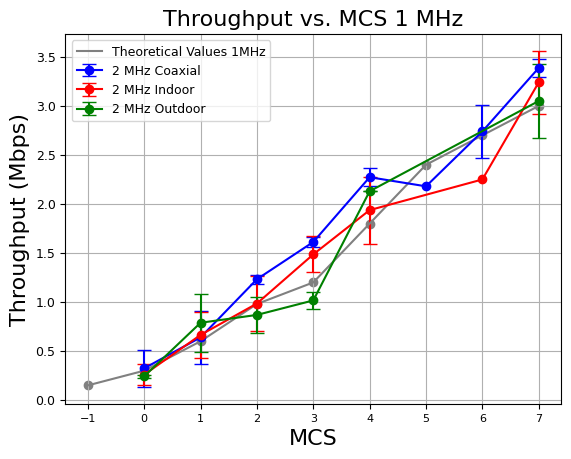

In [28]:
def plot_RX_vs_mcs_theoretical(color1, color2):
    

    mcs_val = list(range(-1, 8))
    
    th_values_1M= [0.15, 0.3, 0.6, 0.98, 1.2, 1.8, 2.4, 2.7, 3.0]
    plt.scatter(mcs_val, th_values_1M, color='grey')
    plt.plot(mcs_val, th_values_1M, color='grey', label='Theoretical Values 1MHz')
    # mcs_val_2M = list(range(0, 8))
    # th_values_2M = [0.65,1.3,1.95,2.6,3.9,5.2,5.85,6.5]
    # plt.scatter(mcs_val_2M, th_values_2M, color=color2)
    # plt.plot(mcs_val_2M, th_values_2M, color=color2, label='Theoretical Values 2MHz')


def plot_RX_throughput_vs_mcs(df_measurements, label, color):
    # Replace MCS 10 with -1
    df_measurements['MCS'] = df_measurements['MCS'].replace(10, -1)

    # Group by MCS and calculate the statistics
    grouped = df_measurements.groupby('MCS')['RX iPerf Bitrate (Mbits/sec)']
    mean_throughput = grouped.mean()
    std_throughput = grouped.std()
    q1_throughput = grouped.quantile(0.25)
    q3_throughput = grouped.quantile(0.75)

    # Prepare data for plotting
    mcs = mean_throughput.index
    mean_values = mean_throughput.values
    std_values = std_throughput.values
    q1_values = q1_throughput.values
    q3_values = q3_throughput.values

    # Plot the mean values with error bars for the standard deviation
    plt.errorbar(mcs, mean_values, yerr=std_values, fmt='-o', capsize=5, label=label, color=color)
    # plt.scatter(df_measurements['MCS'],df_measurements['RX iPerf Bitrate (Mbits/sec)'], marker='x', label=label, color=color, alpha=0.5)
    # Plot the shaded area for the interquartile range
    # plt.fill_between(mcs, q1_values, q3_values, color='gray', alpha=0.2, label='Interquartile Range (1st & 3rd Quartile)')

    # Display statistics for verification
    statistics_df = pd.DataFrame({
        'Mean RX Throughput': mean_throughput,
        'Std Dev RX Throughput': std_throughput,
        '1st Quartile RX Throughput': q1_throughput,
        '3rd Quartile RX Throughput': q3_throughput
    })
    # print(statistics_df)


plot_RX_throughput_vs_mcs(df_coaxial_1M, '1 MHz Coaxial', 'blue')
plot_RX_throughput_vs_mcs(df_indoor_1M, '1 MHz Indoor', 'red')
plot_RX_throughput_vs_mcs(df_outdoor_1M, '1 MHz Outdoor', 'green')
# plot_RX_throughput_vs_mcs(df_2M, '2 MHz', 'green')
plot_RX_vs_mcs_theoretical('black', 'grey')
# Labels and title-
plt.xlabel('MCS', fontsize=16)
plt.ylabel('Throughput (Mbps)', fontsize=16)
plt.title('Throughput vs. MCS 1 MHz',  fontsize=16)
plt.xticks([-1, 0, 1, 2, 3, 4, 5, 6, 7], ['10', '0', '1', '2', '3', '4', '5', '6', '7'], fontsize=9)
plt.yticks(fontsize=9)
plt.grid(True)
plt.legend(fontsize=9)
plt.show()


plot_RX_throughput_vs_mcs(df_coaxial_2M, '2 MHz Coaxial', 'blue')
plot_RX_throughput_vs_mcs(df_indoor_2M, '2 MHz Indoor', 'red')
plot_RX_throughput_vs_mcs(df_outdoor_2M, '2 MHz Outdoor', 'green')
# plot_RX_throughput_vs_mcs(df_2M, '2 MHz', 'green')
plot_RX_vs_mcs_theoretical('black', 'grey')
# Labels and title-
plt.xlabel('MCS', fontsize=16)
plt.ylabel('Throughput (Mbps)', fontsize=16)
plt.title('Throughput vs. MCS 1 MHz',  fontsize=16)
plt.yticks(fontsize=9)
plt.grid(True)
plt.legend(fontsize=9)
plt.show()

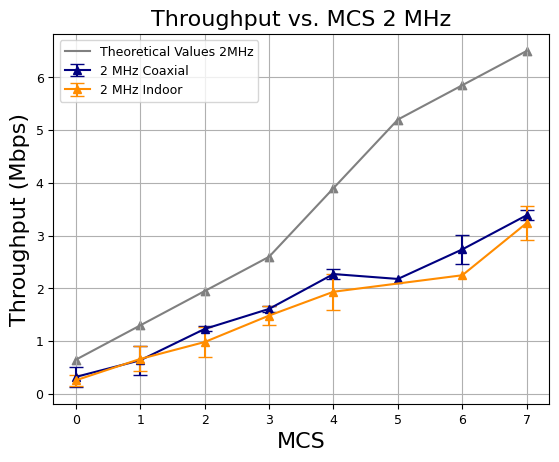

In [29]:
def plot_RX_vs_mcs_theoretical(color1, color2):
    

    mcs_val = list(range(-1, 8))
    
    # th_values_1M= [0.15, 0.3, 0.6, 0.98, 1.2, 1.8, 2.4, 2.7, 3.0]
    # plt.scatter(mcs_val, th_values_1M, color='grey')
    # plt.plot(mcs_val, th_values_1M, color='grey', label='Theoretical Values 1MHz')
    mcs_val_2M = list(range(0, 8))
    th_values_2M = [0.65,1.3,1.95,2.6,3.9,5.2,5.85,6.5]
    plt.scatter(mcs_val_2M, th_values_2M, color=color2, marker='^')
    plt.plot(mcs_val_2M, th_values_2M, color=color2, label='Theoretical Values 2MHz')


def plot_RX_throughput_vs_mcs(df_measurements, label, color):
    # Replace MCS 10 with -1
    df_measurements['MCS'] = df_measurements['MCS'].replace(10, -1)

    # Group by MCS and calculate the statistics
    grouped = df_measurements.groupby('MCS')['RX iPerf Bitrate (Mbits/sec)']
    mean_throughput = grouped.mean()
    std_throughput = grouped.std()
    q1_throughput = grouped.quantile(0.25)
    q3_throughput = grouped.quantile(0.75)

    # Prepare data for plotting
    mcs = mean_throughput.index
    mean_values = mean_throughput.values
    std_values = std_throughput.values
    q1_values = q1_throughput.values
    q3_values = q3_throughput.values

    # Plot the mean values with error bars for the standard deviation
    plt.errorbar(mcs, mean_values, yerr=std_values, fmt='-^', capsize=5, label=label, color=color)
    # plt.scatter(df_measurements['MCS'],df_measurements['RX iPerf Bitrate (Mbits/sec)'], marker='^', label=label, color=color, alpha=0.5)
    # Plot the shaded area for the interquartile range
    # plt.fill_between(mcs, q1_values, q3_values, color='gray', alpha=0.2, label='Interquartile Range (1st & 3rd Quartile)')

    # Display statistics for verification
    statistics_df = pd.DataFrame({
        'Mean RX Throughput': mean_throughput,
        'Std Dev RX Throughput': std_throughput,
        '1st Quartile RX Throughput': q1_throughput,
        '3rd Quartile RX Throughput': q3_throughput
    })
    # print(statistics_df)


plot_RX_throughput_vs_mcs(df_coaxial_2M, '2 MHz Coaxial', 'navy')
plot_RX_throughput_vs_mcs(df_indoor_2M, '2 MHz Indoor', 'darkorange')
# plot_RX_throughput_vs_mcs(df_2M, '2 MHz', 'green')
plot_RX_vs_mcs_theoretical('black', 'grey')
# Labels and title-
plt.xlabel('MCS', fontsize=16)
plt.ylabel('Throughput (Mbps)', fontsize=16)
plt.title('Throughput vs. MCS 2 MHz',  fontsize=16)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid(True)
plt.legend(fontsize=9)
plt.show()


# Indoor Setting

plotting rssi vs number of walls,
getting average at each walls then having points together

In [30]:
# Extracting of scenarios of specific buildings from indoor logs
indoor_directory = r'data\indoor\logs\results_indoor_STA_1MHz\atrium_tests'
scenario_atrium_1M = extract_scenarios_from_text_files(indoor_directory)
df_atrium_1M = scenarios_to_dataframe(scenario_atrium_1M)

indoor_directory = r'data\indoor\logs\results_indoor_STA_1MHz\CO_tests'
scenario_CO_1M= extract_scenarios_from_text_files(indoor_directory)
df_CO_1M = scenarios_to_dataframe(scenario_CO_1M)

indoor_directory = r'data\indoor\logs\results_indoor_STA_1MHz\BM_tests'
scenario_BM_1M= extract_scenarios_from_text_files(indoor_directory)
df_BM_1M = scenarios_to_dataframe(scenario_BM_1M)

indoor_directory = r'data\indoor\logs\results_indoor_STA_1MHz\vortex_tests'
scenario_vortex_1M= extract_scenarios_from_text_files(indoor_directory) 
df_vortex_1M = scenarios_to_dataframe(scenario_vortex_1M)

indoor_directory = r'data\indoor\logs\results_indoor_STA_1MHz\BC_tests'
scenario_BC_1M= extract_scenarios_from_text_files(indoor_directory)
df_BC_1M = scenarios_to_dataframe(scenario_BC_1M)

indoor_directory = r'data\indoor\logs\results_indoor_STA_2MHz\atrium_tests'
scenarios_atrium_2M = extract_scenarios_from_text_files(indoor_directory)
df_atrium_2M = scenarios_to_dataframe(scenarios_atrium_2M)

indoor_directory = r'data\indoor\logs\results_indoor_STA_2MHz\CO_tests'
scenario_CO_2M= extract_scenarios_from_text_files(indoor_directory)
df_CO_2M = scenarios_to_dataframe(scenario_CO_2M)

indoor_directory = r'data\indoor\logs\results_indoor_STA_2MHz\BM_tests'
scenario_BM_2M= extract_scenarios_from_text_files(indoor_directory)
df_BM_2M = scenarios_to_dataframe(scenario_BM_2M)

indoor_directory = r'data\indoor\logs\results_indoor_STA_2MHz\vortex_tests'
scenario_vortex_2M= extract_scenarios_from_text_files(indoor_directory) 
df_vortex_2M = scenarios_to_dataframe(scenario_vortex_2M)

indoor_directory = r'data\indoor\logs\results_indoor_STA_2MHz\BC_tests'
scenario_BC_2M= extract_scenarios_from_text_files(indoor_directory)
df_BC_2M = scenarios_to_dataframe(scenario_BC_2M)

df_all_wo_vortex = scenarios_to_dataframe(scenario_CO_1M+ scenario_BM_1M + scenario_BC_1M +scenario_atrium_1M)

floor_1_pos_1_1Mhz_indoor_1827.txt
floor_1_pos_2_1Mhz_indoor_1829.txt
floor_1_pos_3_1Mhz_indoor_1830.txt
floor_2_pos_1_1Mhz_indoor_1833.txt
floor_2_pos_2_1Mhz_indoor_1834.txt
floor_2_pos_2_1Mhz_indoor_1836.txt
floor_2_pos_3_1Mhz_indoor_1837.txt
floor_2_pos_3_1Mhz_indoor_1839.txt
point_A_1Mhz_indoor_1544.txt
point_B_1Mhz_indoor_1547.txt
point_C_1Mhz_indoor_1550.txt
point_C_1Mhz_indoor_1552.txt
point_D_1Mhz_indoor_1554.txt
point_D_1Mhz_indoor_1557.txt
point_E_1Mhz_indoor_1600.txt
point_E_1Mhz_indoor_1605.txt
point_E_fixed_10_1Mhz_indoor_1615.txt
floor_1_1Mhz_indoor_1706.txt
floor_1_pos_2_1Mhz_indoor_1707.txt
floor_1_pos_2_1Mhz_indoor_1711.txt
floor_1_pos_3_1Mhz_indoor_1710.txt
floor_2_pos_1_1Mhz_indoor_1715.txt
floor_2_pos_2_1Mhz_indoor_1716.txt
floor_2_pos_2_1Mhz_indoor_1717.txt
floor_2_pos_3_1Mhz_indoor_1719.txt
floor_2_pos_4_1Mhz_indoor_1720.txt
floor_1_pos_1_1Mhz_indoor_1725.txt
floor_1_pos_2_1Mhz_indoor_1726.txt
floor_2_pos_2_1Mhz_indoor_1730.txt
floor_2_pos_3_1Mhz_indoor_1732.txt
f

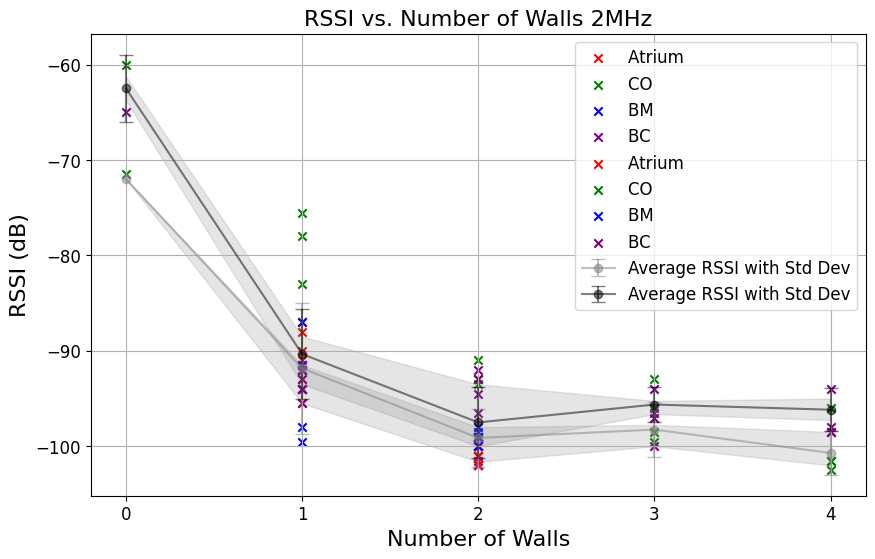

In [31]:
def plot_rssi_vs_walls(df_measurements, color='grey'):
    # Group by number of walls and calculate the statistics
    grouped = df_measurements.groupby('Walls')['RSSI Median']
    mean_rssi = grouped.mean()
    std_rssi = grouped.std()
    q1_rssi = grouped.quantile(0.25)
    q3_rssi = grouped.quantile(0.75)

    # Prepare data for plotting
    walls = mean_rssi.index
    mean_values = mean_rssi.values
    std_values = std_rssi.values
    q1_values = q1_rssi.values
    q3_values = q3_rssi.values

    

    # Plot the mean values with error bars for the standard deviation
    plt.errorbar(walls, mean_values, yerr=std_values, fmt='-o', capsize=5,alpha=0.5, color=color, label='Average RSSI with Std Dev')

    # Plot the shaded area for the interquartile range
    plt.fill_between(walls, q1_values, q3_values, color='gray', alpha=0.2) #, label='Interquartile Range (1st & 3rd Quartile)')


    # Display statistics for verification
    statistics_df = pd.DataFrame({
        'Mean RSSI': mean_rssi,
        'Std Dev RSSI': std_rssi,
        '1st Quartile RSSI': q1_rssi,
        '3rd Quartile RSSI': q3_rssi
    })
    # print(statistics_df)

def plot_scatter_rssi_vs_walls(df_measurements, label, color ='blue'):
    # Prepare data for plotting
    walls = df_measurements['Walls']
    mean_values = df_measurements['RSSI Median']
    # Plot the mean values with error bars for the standard deviation
    plt.scatter(walls, mean_values ,color=color, label=label, marker='x')

# Plotting the graph
plt.figure(figsize=(10, 6))
df_CO_1M['RSSI Median'] += 0.5
plot_scatter_rssi_vs_walls(df_atrium_1M, 'Atrium ', 'red')
plot_scatter_rssi_vs_walls(df_CO_1M, 'CO ', 'green')
plot_scatter_rssi_vs_walls(df_BM_1M, 'BM ', 'blue')
# plot_scatter_rssi_vs_walls(df_vortex_1M, 'Vortex ', 'orange')
plot_scatter_rssi_vs_walls(df_BC_1M, 'BC ', 'purple')

plot_rssi_vs_walls(df_all_wo_vortex)
# Labels and title
plt.xlabel('Number of Walls', fontsize=16)
plt.ylabel('RSSI (dB)', fontsize=16)
plt.title('RSSI vs. Number of Walls 1MHz')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize=12)
plt.grid(True)
# plt.show()

### 2 MHz
# Plotting the graph
# plt.figure(figsize=(10, 6))
df_CO_1M['RSSI Median'] += 0.5
plot_scatter_rssi_vs_walls(df_atrium_2M, 'Atrium ', 'red')
plot_scatter_rssi_vs_walls(df_CO_2M, 'CO ', 'green')
plot_scatter_rssi_vs_walls(df_BM_2M, 'BM ', 'blue')
# plot_scatter_rssi_vs_walls(df_vortex_2M, 'Vortex ', 'orange')
plot_scatter_rssi_vs_walls(df_BC_2M, 'BC ', 'purple')

plot_rssi_vs_walls(df_indoor_2M, 'black')
# Labels and title
plt.xlabel('Number of Walls', fontsize=16)
plt.ylabel('RSSI (dB)', fontsize=16)
plt.title('RSSI vs. Number of Walls 2MHz')
plt.xticks(fontsize = 12)
plt.xticks([0, 1, 2, 3, 4])
plt.yticks(fontsize = 12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


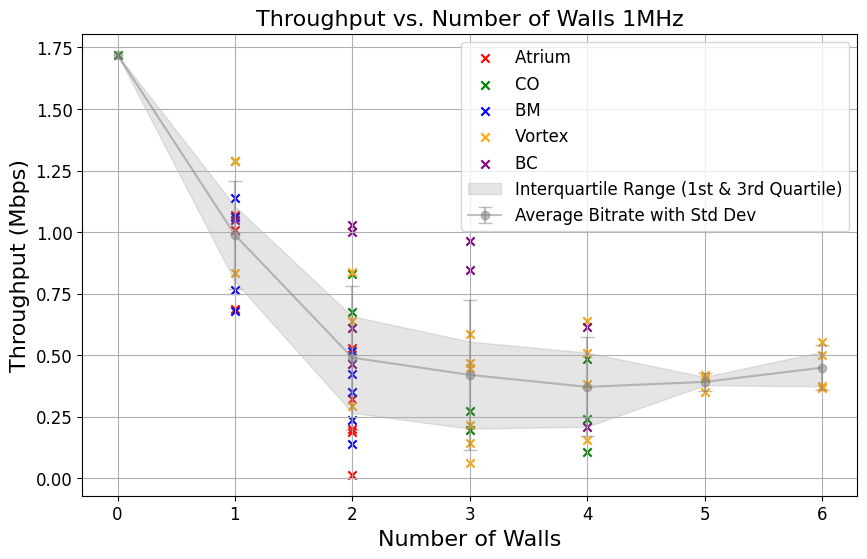

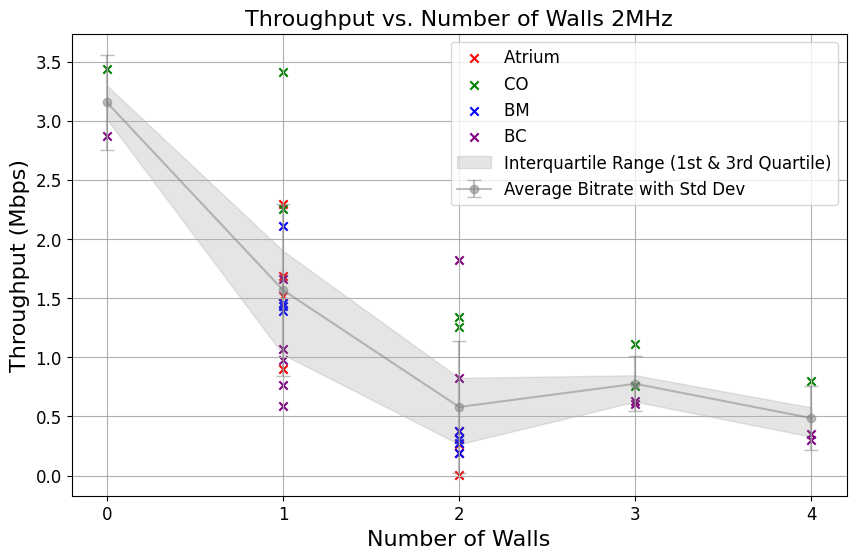

In [32]:
def plot_rssi_vs_walls(df_measurements):
    # Group by number of walls and calculate the statistics
    grouped = df_measurements.groupby('Walls')['RX iPerf Bitrate (Mbits/sec)']
    mean_rssi = grouped.mean()
    std_rssi = grouped.std()
    q1_rssi = grouped.quantile(0.25)
    q3_rssi = grouped.quantile(0.75)

    # Prepare data for plotting
    walls = mean_rssi.index
    mean_values = mean_rssi.values
    std_values = std_rssi.values
    q1_values = q1_rssi.values
    q3_values = q3_rssi.values

    

    # Plot the mean values with error bars for the standard deviation
    plt.errorbar(walls, mean_values, yerr=std_values, fmt='-o', capsize=5,alpha=0.5, color='grey', label='Average Bitrate with Std Dev')

    # Plot the shaded area for the interquartile range
    plt.fill_between(walls, q1_values, q3_values, color='gray', alpha=0.2, label='Interquartile Range (1st & 3rd Quartile)')


    # Display statistics for verification
    statistics_df = pd.DataFrame({
        'Mean RSSI': mean_rssi,
        'Std Dev RSSI': std_rssi,
        '1st Quartile RSSI': q1_rssi,
        '3rd Quartile RSSI': q3_rssi
    })
    # print(statistics_df)

def plot_scatter_rssi_vs_walls(df_measurements, label, color ='blue'):
    # Prepare data for plotting
    walls = df_measurements['Walls']
    mean_values = df_measurements['RX iPerf Bitrate (Mbits/sec)']
    # Plot the mean values with error bars for the standard deviation
    plt.scatter(walls, mean_values ,color=color, label=label, marker='x')

# Plotting the graph
plt.figure(figsize=(10, 6))
df_CO_1M['RSSI Median'] += 0.5
plot_scatter_rssi_vs_walls(df_atrium_1M, 'Atrium ', 'red')
plot_scatter_rssi_vs_walls(df_CO_1M, 'CO ', 'green')
plot_scatter_rssi_vs_walls(df_BM_1M, 'BM ', 'blue')
plot_scatter_rssi_vs_walls(df_vortex_1M, 'Vortex ', 'orange')
plot_scatter_rssi_vs_walls(df_BC_1M, 'BC ', 'purple')

plot_rssi_vs_walls(df_indoor_1M)
# Labels and title
plt.xlabel('Number of Walls', fontsize=16)
plt.ylabel('Throughput (Mbps)', fontsize=16)
plt.title('Throughput vs. Number of Walls 1MHz')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


# Plotting the graph
plt.figure(figsize=(10, 6))
df_CO_1M['RSSI Median'] += 0.5
plot_scatter_rssi_vs_walls(df_atrium_2M, 'Atrium ', 'red')
plot_scatter_rssi_vs_walls(df_CO_2M, 'CO ', 'green')
plot_scatter_rssi_vs_walls(df_BM_2M, 'BM ', 'blue')
# plot_scatter_rssi_vs_walls(df_vortex_1M, 'Vortex ', 'orange')
plot_scatter_rssi_vs_walls(df_BC_2M, 'BC ', 'purple')

plot_rssi_vs_walls(df_indoor_2M)
# Labels and title
plt.xlabel('Number of Walls', fontsize=16)
plt.ylabel('Throughput (Mbps)', fontsize=16)
plt.title('Throughput vs. Number of Walls 2MHz')
plt.xticks(fontsize = 12)
plt.xticks([0, 1, 2, 3, 4])
plt.yticks(fontsize = 12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


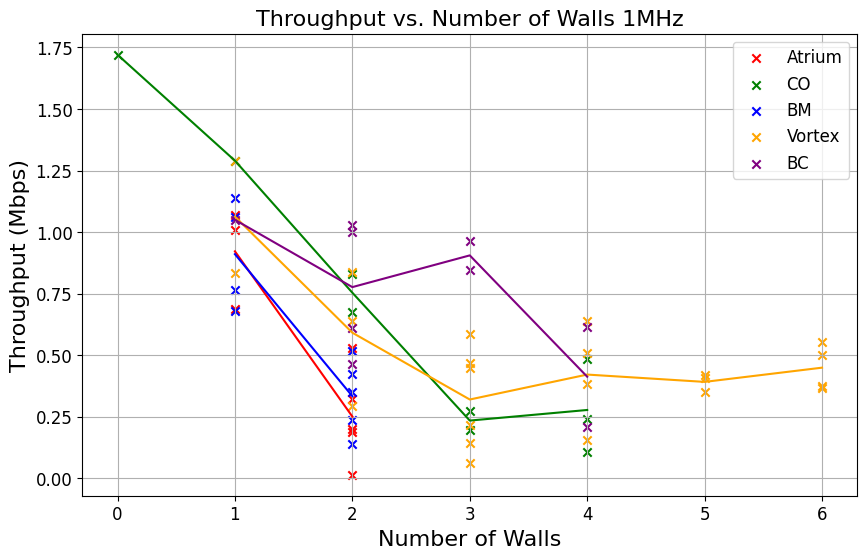

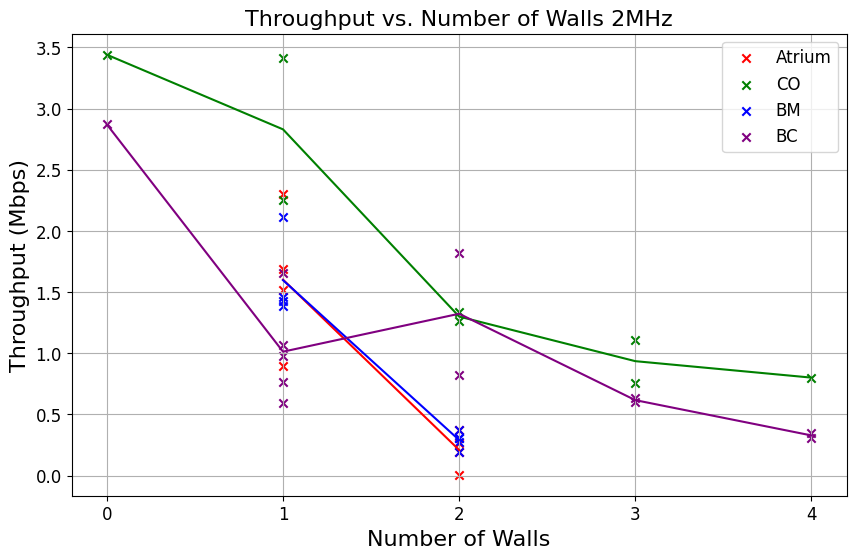

In [33]:
def plot_throughput_vs_walls(df_measurements, color):
    # Group by number of walls and calculate the statistics
    grouped = df_measurements.groupby('Walls')['RX iPerf Bitrate (Mbits/sec)']
    mean_throughput = grouped.mean()
    std_throughput = grouped.std()
    q1_throughput = grouped.quantile(0.25)
    q3_throughput = grouped.quantile(0.75)

    # Prepare data for plotting
    walls = mean_throughput.index
    mean_values = mean_throughput.values
    std_values = std_throughput.values
    q1_values = q1_throughput.values
    q3_values = q3_throughput.values

    # Plot the mean values with error bars for the standard deviation
    plt.errorplot(walls, mean_values, yerr=std_values, fmt='-o', capsize=5, label='Average Throughput with Std Dev', color=color)

    # Plot the shaded area for the interquartile range
    plt.fill_between(walls, q1_values, q3_values, color='gray', alpha=0.2, label='Interquartile Range (1st & 3rd Quartile)')

    # Display statistics for verification
    statistics_df = pd.DataFrame({
        'Mean Throughput': mean_throughput,
        'Std Dev Throughput': std_throughput,
        '1st Quartile Throughput': q1_throughput,
        '3rd Quartile Throughput': q3_throughput
    })
    # print(statistics_df)

def plot_scatter_throughput_vs_walls(df_measurements, label, color ='blue'):
    # Prepare data for plotting
    walls = df_measurements['Walls']
    mean_values = df_measurements['RX iPerf Bitrate (Mbits/sec)'] 
    plt.scatter(walls, mean_values, color=color, label=label, marker='x')

    grouped = df_measurements.groupby('Walls')['RX iPerf Bitrate (Mbits/sec)']
    mean_throughput = grouped.mean()
    walls = mean_throughput.index
    mean_tp = mean_throughput.values
    plt.plot(walls, mean_tp, color=color)

    # Plot the mean values with error bars for the standard deviation

# Plotting the graph
plt.figure(figsize=(10, 6))
plot_scatter_throughput_vs_walls(df_atrium_1M, 'Atrium', 'red')
plot_scatter_throughput_vs_walls(df_CO_1M, 'CO', 'green')
plot_scatter_throughput_vs_walls(df_BM_1M, 'BM', 'blue')
plot_scatter_throughput_vs_walls(df_vortex_1M, 'Vortex', 'orange')
plot_scatter_throughput_vs_walls(df_BC_1M, 'BC', 'purple')

# plot_throughput_vs_walls(df_atrium_1M, 'red')

# Labels and title
plt.xlabel('Number of Walls', fontsize=16)
plt.ylabel('Throughput (Mbps)' , fontsize=16)
plt.title('Throughput vs. Number of Walls 1MHz')
plt.grid(True)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize =12)
plt.show()


# Plotting the graph
plt.figure(figsize=(10, 6))
plot_scatter_throughput_vs_walls(df_atrium_2M, 'Atrium', 'red')
plot_scatter_throughput_vs_walls(df_CO_2M, 'CO', 'green')
plot_scatter_throughput_vs_walls(df_BM_2M, 'BM', 'blue')
# plot_scatter_throughput_vs_walls(df_vortex_1M, 'Vortex', 'orange')
plot_scatter_throughput_vs_walls(df_BC_2M, 'BC', 'purple')

# plot_throughput_vs_walls(df_atrium_1M, 'red')

# Labels and title
plt.xlabel('Number of Walls', fontsize=16)
plt.ylabel('Throughput (Mbps)' , fontsize=16)
plt.title('Throughput vs. Number of Walls 2MHz')
plt.grid(True)
plt.xticks(fontsize = 12)
plt.xticks([0, 1, 2, 3, 4])
plt.yticks(fontsize = 12)
plt.legend(fontsize =12)
plt.show()

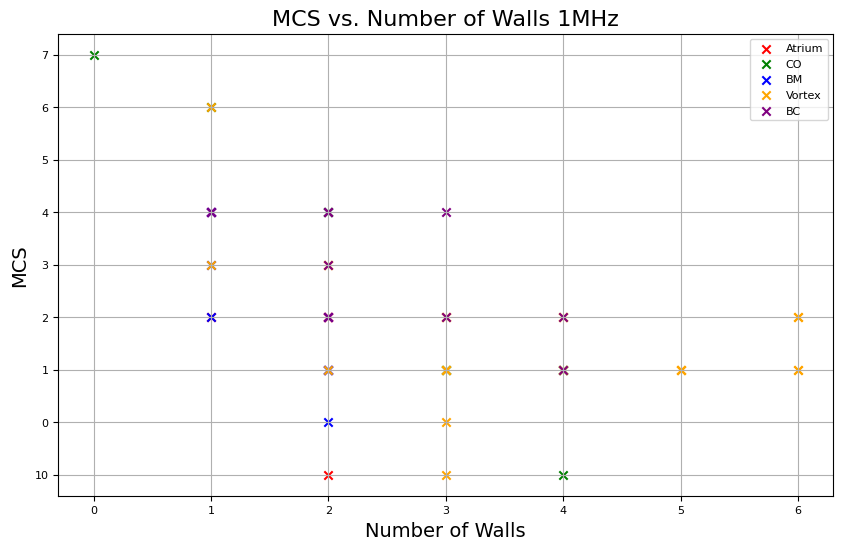

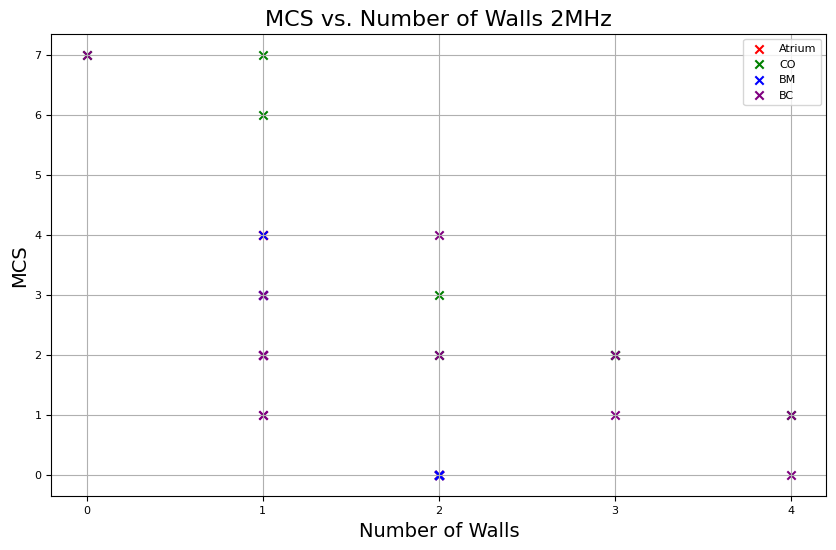

In [34]:
def plot_mcs_vs_walls(df_measurements):
    df_measurements['MCS'] = df_measurements['MCS'].replace(10, -1)

    # Group by number of walls and calculate the statistics
    grouped = df_measurements.groupby('Walls')['MCS']
    mean_mcs = grouped.mean()
    std_mcs = grouped.std()
    q1_mcs = grouped.quantile(0.25)
    q3_mcs = grouped.quantile(0.75)

    # Prepare data for plotting
    walls = mean_mcs.index
    mean_values = mean_mcs.values
    std_values = std_mcs.values
    q1_values = q1_mcs.values
    q3_values = q3_mcs.values

    # Plot the mean values with error bars for the standard deviation
    plt.errorbar(walls, mean_values, yerr=std_values, fmt='-o', capsize=5, label='Average MCS with Std Dev', color='grey', alpha=0.5)

    # Plot the shaded area for the interquartile range
    plt.fill_between(walls, q1_values, q3_values, color='gray', alpha=0.2, label='Interquartile Range (1st & 3rd Quartile)')

    # Display statistics for verification
    statistics_df = pd.DataFrame({
        'Mean MCS': mean_mcs,
        'Std Dev MCS': std_mcs,
        '1st Quartile MCS': q1_mcs,
        '3rd Quartile MCS': q3_mcs
    })
    print(statistics_df)

def plot_scatter_mcs_vs_walls(df_measurements, label, color='blue'):
    df_measurements['MCS'] = df_measurements['MCS'].replace(10, -1)

    # Prepare data for plotting
    walls = df_measurements['Walls']
    mean_values = df_measurements['MCS']

    # Plot the mean values with error bars for the standard deviation
    plt.scatter(walls, mean_values, color=color, label=label, marker='x')


# Plotting the graph
plt.figure(figsize=(10, 6))
plot_scatter_mcs_vs_walls(df_atrium_1M, 'Atrium', 'red')
plot_scatter_mcs_vs_walls(df_CO_1M, 'CO', 'green')
plot_scatter_mcs_vs_walls(df_BM_1M, 'BM', 'blue')
plot_scatter_mcs_vs_walls(df_vortex_1M, 'Vortex', 'orange')
plot_scatter_mcs_vs_walls(df_BC_1M, 'BC', 'purple')

# plot_mcs_vs_walls(df_all_wo_vortex)

# Labels and title
plt.xlabel('Number of Walls')
plt.ylabel('MCS')
plt.title('MCS vs. Number of Walls 1MHz')
plt.yticks([-1, 0, 1, 2, 3, 4, 5, 6, 7], ['10', '0', '1', '2', '3', '4', '5', '6', '7'])

plt.grid(True)
plt.legend()
plt.show()


# Plotting the graph
plt.figure(figsize=(10, 6))
plot_scatter_mcs_vs_walls(df_atrium_2M, 'Atrium', 'red')
plot_scatter_mcs_vs_walls(df_CO_2M, 'CO', 'green')
plot_scatter_mcs_vs_walls(df_BM_2M, 'BM', 'blue')
# plot_scatter_mcs_vs_walls(df_vortex_1M, 'Vortex', 'orange')
plot_scatter_mcs_vs_walls(df_BC_2M, 'BC', 'purple')

# plot_mcs_vs_walls(df_all_wo_vortex)

# Labels and title
plt.xlabel('Number of Walls')
plt.ylabel('MCS')
plt.title('MCS vs. Number of Walls 2MHz')
plt.xticks([0, 1, 2, 3, 4])

plt.grid(True)
plt.legend()
plt.show()

0       0
1     100
2     100
3     150
4     150
5     150
6     200
7     250
8      25
9     275
10     50
11     50
12    170
Name: Distance, dtype: int64


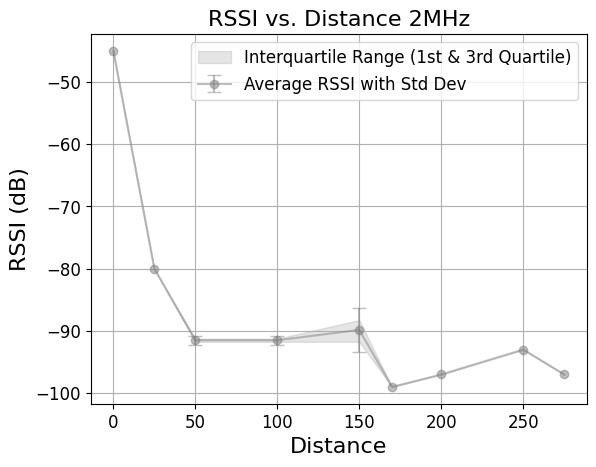

In [35]:
def plot_rssi_vs_walls(df_measurements, color='grey'):
    # Group by number of walls and calculate the statistics
    # Plot the mean values with error bars for the standard deviation
    # df_measurements['Distance']
    # plt.plot(df_measurements['Distance'], df_measurements['RSSI Median'], color=color, label='Average RSSI with Std Dev')

    # Group by number of walls and calculate the statistics
    grouped = df_measurements.groupby('Distance')['RSSI Median']
    mean_rssi = grouped.mean()
    std_rssi = grouped.std()
    q1_rssi = grouped.quantile(0.25)
    q3_rssi = grouped.quantile(0.75)

    # Prepare data for plotting
    distance = mean_rssi.index
    mean_values = mean_rssi.values
    std_values = std_rssi.values
    q1_values = q1_rssi.values
    q3_values = q3_rssi.values

    # Plot the mean values with error bars for the standard deviation
    plt.errorbar(distance, mean_values, yerr=std_values, fmt='-o', capsize=5, label='Average RSSI with Std Dev', color='grey', alpha=0.5)

    # Plot the shaded area for the interquartile range
    plt.fill_between(distance, q1_values, q3_values, color='gray', alpha=0.2, label='Interquartile Range (1st & 3rd Quartile)')

print(df_outdoor_2M['Distance'])
plot_rssi_vs_walls(df_outdoor_2M, 'black')
# Labels and title
plt.xlabel('Distance', fontsize=16)
plt.ylabel('RSSI (dB)', fontsize=16)
plt.title('RSSI vs. Distance 2MHz')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()




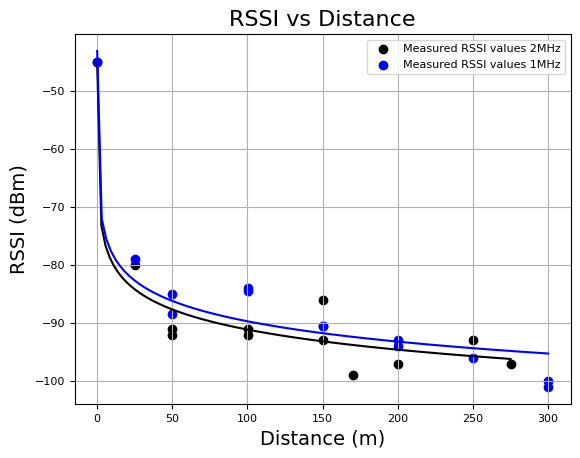

In [36]:
# Define the function for the logarithmic curve
def log_curve(x, a, b):
    return a * np.log(x) + b

# Example RSSI and distance values
def log_curve_fit(df_measurements, color='red', bw='1'):
    # Replace these lists with your actual measurements
    distances = df_measurements['Distance'] + 0.01
    rssi_values = df_measurements['RSSI Median']

    # Fit the logarithmic curve
    popt, pcov = curve_fit(log_curve, distances, rssi_values)

    # Generate x values for the fitted curve
    x_fit = np.linspace(min(distances), max(distances), 100)
    y_fit = log_curve(x_fit, *popt)

    # Plot the data points and the fitted curve
    plt.scatter(distances, rssi_values, color=color, label=f'Measured RSSI values {bw}MHz')
    plt.plot(x_fit, y_fit, color=color) #, label=f'Fitted Log Curve: y = {popt[0]:.2f} * log(x) + {popt[1]:.2f}')

log_curve_fit(df_outdoor_2M, 'black', 2)
log_curve_fit(df_outdoor_1M, 'blue', 1)
plt.xlabel('Distance (m)')
plt.ylabel('RSSI (dBm)')
plt.title('RSSI vs Distance')
plt.legend()
plt.grid(True)
plt.show()